In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')

### 1. Обучить AE собственной архитектуры на MNIST

In [2]:
#hyper params
num_epoch = 5
cuda_device = -1
batch_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
class Encoder(nn.Module):
    # 28*28 -> hidden -> out
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.15)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.15)
        self.linear3 = nn.Linear(hidden_dim, latent_dim)

        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.activation(self.linear1(x)))
        x = self.dropout2(self.activation(self.linear2(x)))
        x = self.activation(self.linear3(x))

        return x


class Decoder(nn.Module):
    # encoder_out -> hidden -> 28*28
    def __init__(self, latent_dim, hidden_dim, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.15)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.15)
        self.linear3 = nn.Linear(hidden_dim, out_dim)

        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.activation(self.linear1(x)))
        x = self.dropout2(self.activation(self.linear2(x)))
        x = self.activation(self.linear3(x))

        return x


class ClassicAutoEncoder(nn.Module):
    def __init__(self, input_dim, enc_hidden_dim, dec_hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, enc_hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, dec_hidden_dim, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [5]:
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

In [6]:
model = ClassicAutoEncoder(28*28, 200, 300, 32)
model.train()
model.to(device)

ClassicAutoEncoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=200, bias=True)
    (dropout1): Dropout(p=0.15, inplace=False)
    (linear2): Linear(in_features=200, out_features=200, bias=True)
    (dropout2): Dropout(p=0.15, inplace=False)
    (linear3): Linear(in_features=200, out_features=32, bias=True)
    (activation): Sigmoid()
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=32, out_features=300, bias=True)
    (dropout1): Dropout(p=0.15, inplace=False)
    (linear2): Linear(in_features=300, out_features=300, bias=True)
    (dropout2): Dropout(p=0.15, inplace=False)
    (linear3): Linear(in_features=300, out_features=784, bias=True)
    (activation): Sigmoid()
  )
)

In [7]:
#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
#dataset
dataset = datasets.MNIST('.', download=False)

In [10]:
#loss
loss_func = nn.MSELoss()

In [12]:
#dataloder
for epoch in range(num_epoch):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    print(f'epoch: {epoch}')
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).view(batch['data'].size(0), -1)
        optim.zero_grad()
        predict = model(data)
        loss = loss_func(predict, data)
        loss.backward()
        optim.step()
        if (step % 100 == 0):
            print(loss)

epoch: 0
tensor(0.0394, grad_fn=<MseLossBackward0>)
tensor(0.0398, grad_fn=<MseLossBackward0>)
tensor(0.0415, grad_fn=<MseLossBackward0>)
tensor(0.0403, grad_fn=<MseLossBackward0>)
tensor(0.0379, grad_fn=<MseLossBackward0>)
epoch: 1
tensor(0.0385, grad_fn=<MseLossBackward0>)
tensor(0.0380, grad_fn=<MseLossBackward0>)
tensor(0.0376, grad_fn=<MseLossBackward0>)
tensor(0.0358, grad_fn=<MseLossBackward0>)
tensor(0.0348, grad_fn=<MseLossBackward0>)
epoch: 2
tensor(0.0350, grad_fn=<MseLossBackward0>)
tensor(0.0342, grad_fn=<MseLossBackward0>)
tensor(0.0335, grad_fn=<MseLossBackward0>)
tensor(0.0323, grad_fn=<MseLossBackward0>)
tensor(0.0353, grad_fn=<MseLossBackward0>)
epoch: 3
tensor(0.0350, grad_fn=<MseLossBackward0>)
tensor(0.0334, grad_fn=<MseLossBackward0>)
tensor(0.0333, grad_fn=<MseLossBackward0>)
tensor(0.0329, grad_fn=<MseLossBackward0>)
tensor(0.0341, grad_fn=<MseLossBackward0>)
epoch: 4
tensor(0.0315, grad_fn=<MseLossBackward0>)
tensor(0.0332, grad_fn=<MseLossBackward0>)
tensor(0.

In [17]:
with torch.no_grad():
    model.eval()
    test = dataset.data[1].view(1,-1).long() / 255
    test = test.to(device)
    predict = model(test)
    test = test[0].view(28, 28).detach().cpu().numpy()
    print((test*255).astype(int).sum())

31095


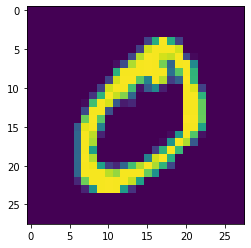

In [18]:
plt.imshow(test)
plt.show()

### 2. Обучить VAE собственной архитектуры на MNIST

In [19]:
num_epoch = 10
cuda_device = -1
batch_size = 256
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
class Encoder(nn.Module):
    # 28*28 -> hidden -> out
    def __init__(self, in_chan, hidden_ch, out_channels):
        super().__init__()
        #conv2d -> maxpool2d -> conv2d -> maxpool2d -> conv2d
        self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5, stride=1, padding=2) # 28 x28
        self.pool1 = nn.MaxPool2d(2, 2) # 14 x 14
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)  # 14 x 14
        self.pool2 = nn.MaxPool2d(2, 2)  # 7 x 7
        self.conv_mu = nn.Conv2d(hidden_ch, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv_sigma = nn.Conv2d(hidden_ch, out_channels, kernel_size=3, stride=1, padding=1)

        self.activation = nn.Sigmoid()

    def forward(self, x): # -> 7x7
        x = self.activation(self.pool1(self.conv1(x)))
        x = self.activation(self.pool2(self.conv2(x)))
        mu = self.activation(self.conv_mu(x))
        sigma = torch.exp(self.conv_sigma(x))

        return mu, sigma
    
class Decoder(nn.Module):
    #conv2d -> upsampling2d -> conv2d -> upsampling2d -> conv2d
    def __init__(self, in_chan, hidden_ch, out_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=3, stride=1, padding=1)  # 7 x 7
        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor=2)  # 14 x 14
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)  # 14 x 14
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)  # 28 x 28
        self.conv3 = nn.Conv2d(hidden_ch, out_chan, kernel_size=5, stride=1, padding=2)

        self.activation = nn.Sigmoid()

    def forward(self, x): # -> 28 x 28
        x = self.activation(self.upsample1(self.conv1(x)))
        x = self.activation(self.upsample2(self.conv2(x)))
        x = self.activation(self.conv3(x))

        return x


class VarAutoEncoder(nn.Module):
    def __init__(self, input_ch, enc_hidden_ch, dec_hidden_ch, latent_ch):
        super().__init__()
        self.encoder = Encoder(input_ch, enc_hidden_ch, latent_ch)
        self.decoder = Decoder(latent_ch, dec_hidden_ch, input_ch)

    def forward(self, x):
        mu, sigma = self.encoder(x)
        x = sampling(mu, sigma)
        x = self.decoder(x)

        return x, mu, sigma


# sampling
def sampling(mu, sigma):
    return mu + sigma * torch.normal(torch.zeros_like(sigma),
                                     torch.ones_like(sigma))


def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))

    return torch.distributions.kl_divergence(p, q).mean()

In [21]:
model_vae = VarAutoEncoder(1, 10, 10, 1)
model_vae.train()
model_vae.to(device)

VarAutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_mu): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_sigma): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): Sigmoid()
  )
  (decoder): Decoder(
    (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upsample1): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upsample2): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (conv3): Conv2d(10, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (activation): Sigmoid()
  )
)

In [22]:
#optimizer
optim = torch.optim.Adam(model_vae.parameters(), lr=0.001)

In [23]:
#loss
criterion = nn.MSELoss()

In [26]:
for epoch in range(num_epoch):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    print(f'epoch: {epoch}')
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).unsqueeze(1)
        optim.zero_grad()
        predict, mu, sigma = model_vae(data)
        #loss
        kl = kl_loss(mu, sigma)
        crit_loss = criterion(data, predict)
        loss = 0.1 * kl + crit_loss
        loss.backward()
        optim.step()
        if (step % 100 == 0):
            print(f'kl_loss: {kl.item()}, criterion_loss: {crit_loss.item()}')

epoch: 0
kl_loss: 0.004905720241367817, criterion_loss: 0.10077963024377823
kl_loss: 0.0015488872304558754, criterion_loss: 0.09624964743852615
kl_loss: 0.0008056904189288616, criterion_loss: 0.09102003276348114
epoch: 1
kl_loss: 0.0006759946700185537, criterion_loss: 0.08561217039823532
kl_loss: 0.00044096438796259463, criterion_loss: 0.08443830162286758
kl_loss: 0.00031492026755586267, criterion_loss: 0.08199407905340195
epoch: 2
kl_loss: 0.00028456305153667927, criterion_loss: 0.08607540279626846
kl_loss: 0.00021831518097314984, criterion_loss: 0.0849464014172554
kl_loss: 0.00017418881179764867, criterion_loss: 0.0817333310842514
epoch: 3
kl_loss: 0.000161705058417283, criterion_loss: 0.08153034746646881
kl_loss: 0.00013345308252610266, criterion_loss: 0.08261124044656754
kl_loss: 0.0001132567340391688, criterion_loss: 0.07999932020902634
epoch: 4
kl_loss: 0.00010759594442788512, criterion_loss: 0.08051405102014542
kl_loss: 9.385337762068957e-05, criterion_loss: 0.08101602643728256


In [27]:
with torch.no_grad():
    model_vae.eval()
    test = dataset.data[255].unsqueeze(0).unsqueeze(0).float() / 255
    test = test.to(device)
    predict = model_vae(test)
    test = test[0].view(28, 28).detach().cpu().numpy()
    print((test*255).astype(int).sum())

33676
